#### for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import distinctipy
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from tNo module named 'some_librarytorch_geometric.nn import GATConv'

In [128]:
# for my pc
url_living_to_all = "/workspace/Floor_plan_generation/dataset/Planify_Graphs_Scaled/Planify_Graphs_Scaled/Graphs_living_to_all.pkl"
url_boundary = r"/workspace/Floor_plan_generation/dataset/Planify_Graphs_Scaled/Planify_Graphs_Scaled/boundaries.pkl"


In [129]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wapip install torch-geometric
ll', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [130]:
def draw_graph_nodes(G, living_to_all=False):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    color_map = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    edge_labels = nx.get_edge_attributes(G, 'distance')

    
    nx.draw_networkx_nodes(G, pos=pos, node_size=scales, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos, edge_color='b');
    nx.draw_networkx_labels(G, pos=pos, font_size=8);

    if living_to_all:
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

    
    # # Drawing the graph inside a good boundary.
    # x_coords  = [pos[node][0] for node in pos]
    # y_coords  = [pos[node][1] for node in pos]
    # threshold = max(scales) / 100
    
    # plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)
    

def draw_graph_boundary(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}
    
    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]
    
    # nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)
    nx.draw_networkx_nodes(G, pos=pos, node_size=150, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos)
    
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)
    
    
# For statistics
def get_max_min_x_y(graphs):
    max_x = 0
    max_y = 0
    min_x = float('inf')
    min_y = float('inf')
    
    for G in tqdm(graphs, desc="Getting maximum x, y", total=len(graphs)):
        max_x_in_graph = G.x.T[1].max().item()
        max_y_in_graph = G.x.T[2].max().item()
        
        min_x_in_graph = G.x.T[1].min().item()
        min_y_in_graph = G.x.T[2].min().item()
        
        if max_x_in_graph > max_x:
            max_x = max_x_in_graph
        if max_y_in_graph > max_y:
            max_y = max_y_in_graph
            
        if min_x_in_graph < min_x:
            min_x = min_x_in_graph
        if min_y_in_graph < min_y:
       No module named 'some_library'     min_y = min_y_in_graph
            
    values = {'max_x': max_x, 'max_y': max_y, 'min_x': min_x, 'min_y': min_y}
    return values


def get_all_x_y(graphs):
    """Get all values of x and y from all graphs
        Input: list of graphs
        Output: x and y as pandas series
    """
    x = []
    y = []
    for i, G in tqdm(enumerate(graphs), desc="getting all Xs, Ys", total=len(graphs)):
        for i in range(len(G.x)):
            x.append(G.x[i][1].item())
            y.append(G.x[i][2].item())
            

    x = pd.Series(x)
    y = pd.Series(y)

    return x, y

def boxplot_centrValues(x, y):
    fig, ax = plt.subplots()

    # Plot the boxplots
    ax.boxplot([x, y])

    # Set the xtick labels
    ax.set_xticklabels(['x', 'y'])

    # Add axis labels and title
    ax.set_xlabel('Data')
    ax.set_ylabel('Value')
    ax.set_title('Boxplot of x and y in all graphs')

    # Show the plot
    plt.show()
    

def plot_histograms(x, y):
    x.hist(density=True, bins=100, alpha=0.6, label='x');
    y.hist(density=True, bins=100, alpha=0.3, label='y');
    plt.legend();
    plt.title('Distribution of x and y');


In [131]:
with open(url_living_to_all, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)


Graph with 8 nodes and 7 edges


In [132]:
with open(url_boundary, 'rb') as f:
    boundaries = pickle.load(f)
    
b = boundaries[1911]
print(b)

Graph with 9 nodes and 9 edges


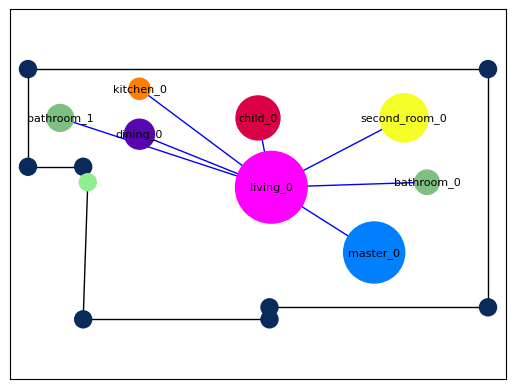

In [133]:
draw_graph_boundary(b)
draw_graph_nodes(G)


In [134]:
No module named 'some_library'   def convert_networkx_Graphs_to_pyTorchGraphs(G):
    """ Converting networkx graphs to pytorchGeo graphs
    """
    features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    return G_new

Graphs_pyTorch = list(map(convert_networkx_Graphs_to_pyTorchGraphs, Graphs))

Graphs_pyTorch[0]


Data(edge_index=[2, 8], roomType_name=[5], rec_w=[5], rec_h=[5], roomSize=[5], x=[5, 3], edge_attr=[8, 1])

In [135]:
def convert_networkx_Boundaries_to_pyTorchGraphs(b):
    """Converting networkx boundary graphs to PyTorchGeo graphs
    """
    b_new = from_networkx(b, group_node_attrs=['type', 'centroid'], group_edge_attrs=['distance'])
    return b_new

Boundaries_pyTorch = list(map(convert_networkx_Boundaries_to_pyTorchGraphs, boundaries))

Boundaries_pyTorch[0]

Data(edge_index=[2, 18], x=[9, 3], edge_attr=[18, 1])

In [136]:
G_x, G_y = get_all_x_y(Graphs_pyTorch)
G_x.max(), G_y.max(), G_x.min(), G_y.min()


etting all Xs, Ys: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80787/80787 [00:04<00:00, 16223.85it/s]

(247.42583732057415, 247.84313725490196, 10.666666666666666, 8.577319587628866)

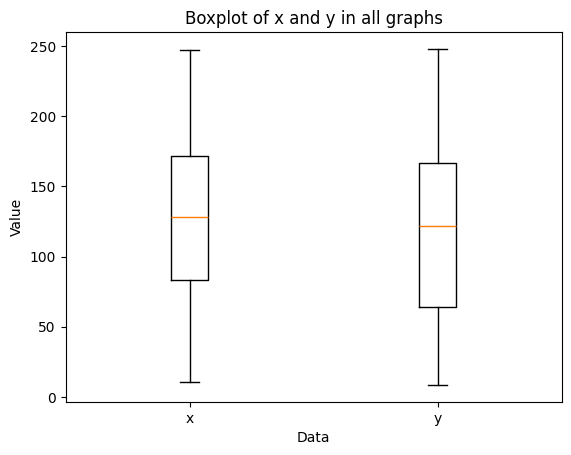

In [137]:
# making box plot for x and y for the graphs
boxplot_centrValues(G_x, G_y)


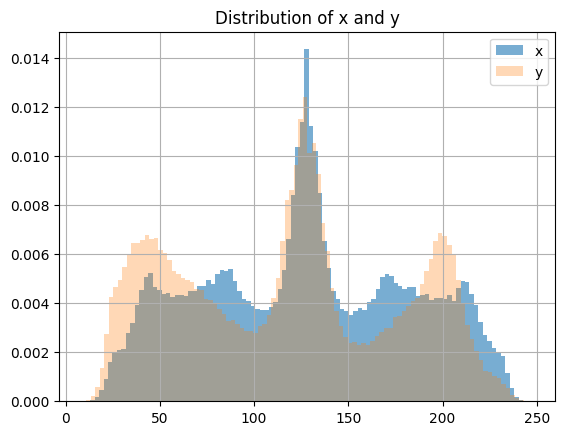

In [138]:
plot_histograms(G_x, G_y)


In [139]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
G_x_mean = G_x.mean()
G_y_mean = G_y.mean()
G_x_std  = G_x.std()
G_y_std  = G_y.std()
print("We will use z-score normalization")


And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


In [140]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6


print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')


Befor: G_1 embedings are: tensor([[  0.0000, 114.4449, 153.2065],
        [  1.0000, 207.2296, 196.9931],
        [  2.0000,  26.6358,  34.7746],
        [  3.0000, 222.7052, 140.5780],
        [  3.0000, 117.2607, 101.8013],
        [  7.0000, 163.5824, 101.4260],
        [  7.0000, 134.9086, 201.0376]], dtype=torch.float64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80787/80787 [00:03<00:00, 22545.73it/s]

After: G_1 embedings are: tensor([[  0.0000, 114.4449, 153.2065],
        [  1.0000, 207.2296, 196.9931],
        [  2.0000,  26.6358,  34.7746],
        [  3.0000, 222.7052, 140.5780],
        [  3.0000, 117.2607, 101.8013],
        [  1.0000, 163.5824, 101.4260],
        [  1.0000, 134.9086, 201.0376]], dtype=torch.float64)


In [141]:
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    
    # Making tensor of means = [x_mean, y_mean] & tensor of stds = [x_std, y_std].
    # We could make a tensor of ones = [rows, 2] then multiply it by the means, But we directly 
    # multiply the means using the idea of "Broadcasting".
    G.x[:, 1:] = (G.x[:, 1:] - torch.tensor([G_x_mean, G_y_mean])) / torch.tensor([G_x_std, G_y_std])
    
    # One hot encoding for the first column [type of rooms]
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
    
    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)


00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80787/80787 [00:07<00:00, 10836.26it/s]

In [142]:
return_to_real = Graphs_pyTorch[1].x[:, [-2, -1]] * torch.tensor([G_x_std, G_y_std]) + torch.Tensor([G_x_mean, G_y_mean])
print(f"Now, we could return back to real values: \n{return_to_real}")

Now, we could return back to real values: 
tensor([[114.4449, 153.2065],
        [207.2296, 196.9931],
        [ 26.6358,  34.7746],
        [222.7052, 140.5780],
        [117.2607, 101.8013],
        [163.5824, 101.4260],
        [134.9086, 201.0376]], dtype=torch.float64)


In [143]:
B_x, B_y = get_all_x_y(Boundaries_pyTorch)
B_x.max(), B_y.max(), B_x.min(), B_y.min()



etting all Xs, Ys: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80787/80787 [00:09<00:00, 8139.92it/s]

(340.0875912408759, 306.0, -57.6, -86.6771653543307)

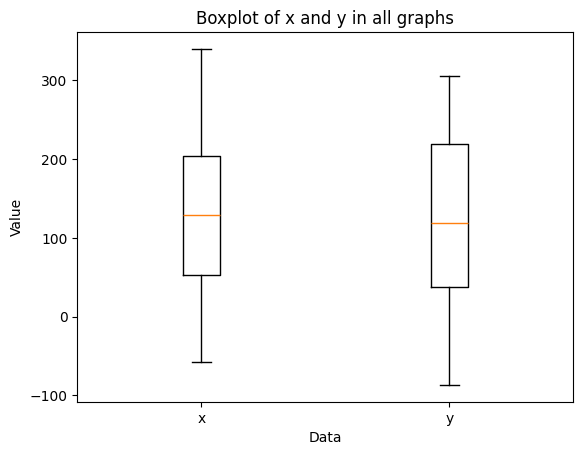

In [144]:
boxplot_centrValues(B_x, B_y)

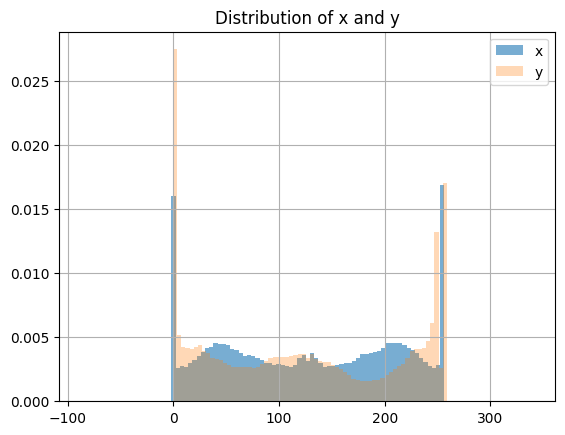

In [145]:
plot_histograms(B_x, B_y)


In [146]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
B_x_mean = B_x.mean()
B_y_mean = B_y.mean()
B_x_std  = B_x.std()
B_y_std  = B_y.std()
print("We will use z-score normpip install torch-geometric
alization")


And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


In [147]:
for b in tqdm(Boundaries_pyTorch, total=len(Boundaries_pyTorch)):
    
    # Making tensor of means = [x_mean, y_mean] & tensor of stds = [x_std, y_std].
    # We could make a tensor of ones = [rows, 2] then multiply it by the means, But we directly 
    # multiply the means using the idea of "Broadcasting".
    b.x[:, 1:] = (b.x[:, 1:] - torch.tensor([B_x_mean, B_y_mean])) / torch.tensor([B_x_std, B_y_std])



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80787/80787 [00:02<00:00, 31106.67it/s]

In [148]:
return_to_real = Boundaries_pyTorch[1].x[:, [-2, -1]] * torch.tensor([B_x_std, B_y_std]) + torch.Tensor([B_x_mean, B_y_mean])
print(f"Now, we could return back to real values: \n{return_to_real}")


Now, we could return back to real values: 
tensor([[ 3.6994e+00,  2.5008e+02],
        [ 1.0136e+02,  2.5008e+02],
        [ 2.5230e+02,  2.4712e+02],
        [ 2.5230e+02,  1.1986e+02],
        [ 1.9755e+02,  1.1986e+02],
        [ 1.9755e+02,  6.6590e+01],
        [ 4.9572e+01,  6.6590e+01],
        [ 4.9572e+01, -1.0978e-06],
        [ 3.6994e+00, -1.0978e-06],
        [ 8.6566e+01,  6.8069e+01]], dtype=torch.float64)


In [149]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

In [150]:
class Planify_Dataset(Dataset):
    def __init__(self, Graphs, Boundaries):
        self.Graphs = Graphs
        self.Boundaries = Boundaries
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone().to(self.device)
        B = self.Boundaries[index].clone().to(self.device)
        B.x = B.x.to(G.x.dtype)
        B.edge_index = B.edge_index.to(G.edge_index.dtype)
        B.edge_attr = B.edge_attr.to(G.edge_attr.dtype)
        
        # shuffling nodes inside the same graph
        # permutation = torch.randperm(G.num_nodes).to(self.device)
        
        # G.x = G.x[permutation]
        # G.edge_index = permutation[G.edge_index]
        # G.rec_w = G.rec_w[permutation]
        # G.rec_h = G.rec_h[permutation]
        # G.edge_attr = G.edge_attr[permutation]
        
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        graphs = {
            'G': G,
            'B': B
        }
        
        return graphs

In [151]:
edge = int(len(Graphs_pyTorch) * 0.8)

In [152]:
batch_size = 32
train_dataset = Planify_Dataset(Graphs_pyTorch[:edge], Boundaries_pyTorch[:edge])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Planify_Dataset(Graphs_pyTorch[edge:-10], Boundaries_pyTorch[edge:-10])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Planify_Dataset(Graphs_pyTorch[-10:], Boundaries_pyTorch[-10:])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"Train dataset: {len(train_dataset)}, Val dataset: {len(val_dataset)}, Test dataset: {len(test_dataset)}")

Train dataset: 64629, Val dataset: 16148, Test dataset: 10


In [153]:
# Saving model function
import os

checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'Best_model_V3.pt')
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)
    
    print('Model saved :)')

In [245]:
from torch_geometric.nn import global_max_pool
class GATNet(torch.nn.Module):
    def __init__(self, num_graph_node_features, num_boundary_node_features):
        super(GATNet, self).__init__()
        
        # Convert input features to float32
        self.register_buffer('dtype_template', torch.FloatTensor([1.0]))
        
        # Graph convolutions
        self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=4)  # out: 128
        self.graph_conv2 = GATConv(32*4, 32, heads=8)  # out: 256
        self.graph_conv3 = GATConv(32*8, 64, heads=8)  # out: 512
        self.graph_conv4 = GATConv(64*8, 128, heads=8)  # out: 1024
        
        # Boundary convolutions
        self.boundary_conv1 = GATConv(num_boundary_node_features, 32, heads=4)  # out: 128
        self.boundary_conv2 = GATConv(128, 32, heads=8)  # out: 256
        
        # After concatenating graph (1024) and boundary (256) features
        total_features = 1024 + 256  # = 1280
        self.Concatination1 = GATConv(total_features, 128, heads=8)  # out: 1024
        
        # Linear layers
        self.width_layer1 = nn.Linear(1024, 128)
        self.height_layer1 = nn.Linear(1024, 128)
        
        self.width_output = nn.Linear(128, 1)
        self.height_output = nn.Linear(128, 1)
        
        self.dropout = torch.nn.Dropout(0.2)
        
    def forward(self, graph, boundary):
        # Ensure input tensors are float32
        x_graph = graph.x.type_as(self.dtype_template)
        g_edge_index = graph.edge_index
        g_edge_attr = graph.edge_attr.type_as(self.dtype_template) if graph.edge_attr is not None else None
        g_batch = graph.batch
            
        x_boundary = boundary.x.type_as(self.dtype_template)
        b_edge_index = boundary.edge_index
        b_edge_attr = boundary.edge_attr.type_as(self.dtype_template) if boundary.edge_attr is not None else None
        b_batch = boundary.batch
            
        NUM_OF_NODES = x_graph.shape[0]
            
        if g_batch is None:
            g_batch = torch.zeros(x_graph.shape[0], dtype=torch.long, device=x_graph.device)
        if b_batch is None:
            b_batch = torch.zeros(x_boundary.shape[0], dtype=torch.long, device=x_boundary.device)
            
        # Graph branch
        x_graph = F.leaky_relu(self.graph_conv1(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph)
            
        x_graph = F.leaky_relu(self.graph_conv2(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph)
            
        x_graph = F.leaky_relu(self.graph_conv3(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph)
            
        x_graph = F.leaky_relu(self.graph_conv4(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph)
            
        # Boundary branch
        x_boundary = F.leaky_relu(self.boundary_conv1(x_boundary, b_edge_index, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
            
        x_boundary = F.leaky_relu(self.boundary_conv2(x_boundary, b_edge_index, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
            
        # Pool boundary features - this creates a single feature vector per graph
        x_boundary_pooled = global_max_pool(x_boundary, b_batch)
            
        # Expand boundary features to match graph nodes
        # First, get the number of graphs in the batch
        if g_batch.dim() == 1:
            num_graphs = g_batch.max().item() + 1
        else:
            num_graphs = 1
                
        # Repeat boundary features for each node in the corresponding graph
        x_boundary_expanded = []
        for i in range(num_graphs):
            # Get nodes belonging to this graph
            if num_graphs > 1:
                mask = (g_batch == i)
                num_nodes_in_graph = mask.sum()
            else:
                num_nodes_in_graph = NUM_OF_NODES
                    
            # Repeat boundary features for each node
            graph_boundary_features = x_boundary_pooled[i:i+1].repeat(num_nodes_in_graph, 1)
            x_boundary_expanded.append(graph_boundary_features)
            
        x_boundary_expanded = torch.cat(x_boundary_expanded, dim=0)
            
        # Concatenate features
        x = torch.cat([x_graph, x_boundary_expanded], dim=1)
            
        # Final convolution and predictions
        x = F.leaky_relu(self.Concatination1(x, g_edge_index))
        x = self.dropout(x)
            
        width = F.relu(self.width_layer1(x))
        width = self.dropout(width)
        width = self.width_output(width)
            
        height = F.relu(self.height_layer1(x))
        height = self.dropout(height)
        
import torch
import torch.nn as nn

height = self.height_output(height)
return width.squeeze(), height.squeeze()


num_graph_node_features = Graphs_pyTorch[0].x.shape[1]
num_boundary_node_features = Boundaries_pyTorch[0].x.shape[1]

model = GATNet(num_graph_node_features, num_boundary_node_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import GATConv, global_max_pool

# class GATNet(torch.nn.Module):
#     def __init__(self, num_graph_node_features, num_boundary_node_features):
#         super(GATNet, self).__init__()
        
#         # Graph convolutions
#         self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=4)  # out: 128
#         self.graph_conv2 = GATConv(128, 32, heads=8)  # out: 256
#         self.graph_conv3 = GATConv(256, 64, heads=8)  # out: 512
#         self.graph_conv4 = GATConv(512, 128, heads=8)  # out: 1024
        
#         # Boundary convolutions
#         self.boundary_conv1 = GATConv(num_boundary_node_features, 32, heads=4)  # out: 128
#         self.boundary_conv2 = GATConv(128, 32, heads=8)  # out: 256
        
#         # After concatenating graph (1024) and boundary (256) features
#         total_features = 1024 + 256  # = 1280
#         self.Concatination1 = GATConv(total_features, 128, heads=8)  # out: 1024
        
#         # Linear layers
#         self.width_layer1 = nn.Linear(1024, 128)
#         self.height_layer1 = nn.Linear(1024, 128)
        
#         self.width_output = nn.Linear(128, 1)
#         self.height_output = nn.Linear(128, 1)
        
#         self.dropout = torch.nn.Dropout(0.2)
        
#         # BatchNorm1d for each layer output
#         self.norm1 = nn.BatchNorm1d(128)  # Matches first GATConv
#         self.norm2 = nn.BatchNorm1d(256)  # Matches second GATConv
#         self.norm3 = nn.BatchNorm1d(512)  # Matches third GATConv
#         self.norm4 = nn.BatchNorm1d(1024) # Matches fourth GATConv
        
#         self.norm_concat = nn.BatchNorm1d(1280)
        
#     def forward(self, graph, boundary):
#         # Ensure input tensors are float32
#         x_graph = graph.x.to(torch.float32)
#         g_edge_index = graph.edge_index
#         g_edge_attr = graph.edge_attr.to(torch.float32) if graph.edge_attr is not None else None
#         g_batch = graph.batch
            
#         x_boundary = boundary.x.to(torch.float32)
#         b_edge_index = boundary.edge_index
#         b_edge_attr = boundary.edge_attr.to(torch.float32) if boundary.edge_attr is not None else None
#         b_batch = boundary.batch
            
#         NUM_OF_NODES = x_graph.shape[0]
            
#         if g_batch is None:
#             g_batch = torch.zeros(x_graph.shape[0], dtype=torch.long, device=x_graph.device)
#         if b_batch is None:
#             b_batch = torch.zeros(x_boundary.shape[0], dtype=torch.long, device=x_boundary.device)
            
#         # Graph branch
#         x_graph = F.leaky_relu(self.graph_conv1(x_graph, g_edge_index, g_edge_attr))
#         x_graph = x_graph.permute(1, 0)  # Reshape for BatchNorm1d
#         x_graph = self.norm1(x_graph)    # Apply BatchNorm1d
#         x_graph = x_graph.permute(1, 0)  # Restore original shape
#         x_graph = self.dropout(x_graph)
            
#         x_graph = F.leaky_relu(self.graph_conv2(x_graph, g_edge_index, g_edge_attr))
#         x_graph = x_graph.permute(1, 0)  # Reshape for BatchNorm1d
#         x_graph = self.norm2(x_graph)    # Apply BatchNorm1d
#         x_graph = x_graph.permute(1, 0)  # Restore original shape
#         x_graph = self.dropout(x_graph)
            
#         x_graph = F.leaky_relu(self.graph_conv3(x_graph, g_edge_index, g_edge_attr))
#         x_graph = x_graph.permute(1, 0)  # Reshape for BatchNorm1d
#         x_graph = self.norm3(x_graph)    # Apply BatchNorm1d
#         x_graph = x_graph.permute(1, 0)  # Restore original shape
#         x_graph = self.dropout(x_graph)
            
#         x_graph = F.leaky_relu(self.graph_conv4(x_graph, g_edge_index, g_edge_attr))
#         x_graph = x_graph.permute(1, 0)  # Reshape for BatchNorm1d
#         x_graph = self.norm4(x_graph)    # Apply BatchNorm1d
#         x_graph = x_graph.permute(1, 0)  # Restore original shape
#         x_graph = self.dropout(x_graph)
            
#         # Boundary branch
#         x_boundary = F.leaky_relu(self.boundary_conv1(x_boundary, b_edge_index, b_edge_attr))
#         x_boundary = self.dropout(x_boundary)
            
#         x_boundary = F.leaky_relu(self.boundary_conv2(x_boundary, b_edge_index, b_edge_attr))
#         x_boundary = self.dropout(x_boundary)
            
#         # Pool boundary features - this creates a single feature vector per graph
#         x_boundary_pooled = global_max_pool(x_boundary, b_batch)
            
#         # Expand boundary features to match graph nodes
#         # First, get the number of graphs in the batch
#         if g_batch.dim() == 1:
#             num_graphs = g_batch.max().item() + 1
#         else:
#             num_graphs = 1
                
#         # Repeat boundary features for each node in the corresponding graph
#         x_boundary_expanded = []
#         for i in range(num_graphs):
#             # Get nodes belonging to this graph
#             if num_graphs > 1:
#                 mask = (g_batch == i)
#                 num_nodes_in_graph = mask.sum()
#             else:
#                 num_nodes_in_graph = NUM_OF_NODES
                    
#             # Repeat boundary features for each node
#             graph_boundary_features = x_boundary_pooled[i:i+1].repeat(num_nodes_in_graph, 1)
#             x_boundary_expanded.append(graph_boundary_features)
            
#         x_boundary_expanded = torch.cat(x_boundary_expanded, dim=0)
            
#         # Concatenate features
#         x = torch.cat([x_graph, x_boundary_expanded], dim=1)

#         # Apply BatchNorm to concatenated features
#         x = x.permute(1, 0)  # Reshape for BatchNorm1d
#         x = self.norm_concat(x)  # Apply BatchNorm1d for concatenated features
#         x = x.permute(1, 0)  # Restore original shape
#         x = self.dropout(x)
            
#         # Final convolution and predictions
#         x = F.leaky_relu(self.Concatination1(x, g_edge_index))
#         x = self.dropout(x)
            
#         width = F.relu(self.width_layer1(x))
#         width = self.dropout(width)
#         width = self.width_output(width)
            
#         height = F.relu(self.height_layer1(x))
#         height = self.dropout(height)
#         height = self.height_output(height)
            
#         return width.squeeze(), height.squeeze()


# # Define model
# num_graph_node_features = Graphs_pyTorch[0].x.shape[1]
# num_boundary_node_features = Boundaries_pyTorch[0].x.shape[1]

# model = GATNet(num_graph_node_features, num_boundary_node_features)

# # Move to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# # Apply Gradient Clipping Before Each Optimization Step
# for param in model.parameters():
#     param.register_hook(lambda grad: torch.clamp(grad, -1.0, 1.0))

# to monitor the loss & accuracy.
errors = []
acc = []

model       
# class GATNet(torch.nn.Module):
#     def __init__(self, num_graph_node_features, num_boundary_node_features):
#         super(GATNet, self).__init__()
        
#         # Graph convolution layers
#         self.graph_conv1 = GATConv(num_graph_node_features, 64, heads=4)
#         self.graph_bn1 = nn.BatchNorm1d(64 * 4)
        
#         self.graph_conv2 = GATConv(64 * 4, 64, heads=4)
#         self.graph_bn2 = nn.BatchNorm1d(64 * 4)
        
#         self.graph_conv3 = GATConv(64 * 4, 128, heads=4)
#         self.graph_bn3 = nn.BatchNorm1d(128 * 4)
        
#         # Boundary convolution layers
#         self.boundary_conv1 = GATConv(num_boundary_node_features, 64, heads=4)
#         self.boundary_bn1 = nn.BatchNorm1d(64 * 4)
        
#         self.boundary_conv2 = GATConv(64 * 4, 128, heads=4)
#         self.boundary_bn2 = nn.BatchNorm1d(128 * 4)
        
#         # Concatenation layer
#         concat_size = (128 * 4) + (128 * 4)  # graph + boundary features
#         self.concat_conv = GATConv(concat_size, 256, heads=4)
#         self.concat_bn = nn.BatchNorm1d(256 * 4)
        
#         # Output layers
#         self.width_fc1 = nn.Linear(256 * 4, 128)
#         self.width_bn = nn.BatchNorm1d(128)
#         self.width_fc2 = nn.Linear(128, 1)
        
#         self.height_fc1 = nn.Linear(256 * 4, 128)
#         self.height_bn = nn.BatchNorm1d(128)
#         self.height_fc2 = nn.Linear(128, 1)
        
#         self.dropout = nn.Dropout(0.1)
#         self.act = nn.LeakyReLU(0.2)
        
#     def forward(self, graph, boundary):
#         # Process graph data
#         x_graph = graph.x
#         edge_index = graph.edge_index
        
#         # Graph convolutions with residual connections
#         x1 = self.act(self.graph_bn1(self.graph_conv1(x_graph, edge_index)))
#         x1 = self.dropout(x1)
        
#         x2 = self.act(self.graph_bn2(self.graph_conv2(x1, edge_index)))
#         x2 = self.dropout(x2)
#         x2 = x2 + x1  # Residual connection
        
#         x3 = self.act(self.graph_bn3(self.graph_conv3(x2, edge_index)))
#         x3 = self.dropout(x3)
#         x3 = x3 + x2  # Residual connection
        
#         # Process boundary data
#         x_boundary = boundary.x
#         boundary_edge_index = boundary.edge_index
        
#         b1 = self.act(self.boundary_bn1(self.boundary_conv1(x_boundary, boundary_edge_index)))
#         b1 = self.dropout(b1)
        
#         b2 = self.act(self.boundary_bn2(self.boundary_conv2(b1, boundary_edge_index)))
#         b2 = self.dropout(b2)
        
#         # Global pooling for boundary features
#         b_pooled = torch.mean(b2, dim=0, keepdim=True)
#         b_pooled = b_pooled.repeat(x3.size(0), 1)
        
#         # Concatenate and process
#         x = torch.cat([x3, b_pooled], dim=1)
#         x = self.act(self.concat_bn(self.concat_conv(x, edge_index)))
#         x = self.dropout(x)
        
#         # Width prediction
#         width = self.act(self.width_bn(self.width_fc1(x)))
#         width = self.dropout(width)
#         width = self.width_fc2(width)
        
#         # Height prediction
#         height = self.act(self.height_bn(self.height_fc1(x)))
#         height = self.dropout(height)
#         height = self.height_fc2(height)
        
#         return width.squeeze(), height.squeeze()
# num_graph_node_features = Graphs_pyTorch[0].x.shape[1]
# num_boundary_node_features = Boundaries_pyTorch[0].x.shape[1]

# model = GATNet(num_graph_node_features, num_boundary_node_features)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# # to monitor the loss & accuracy.
# errors = []
# acc = []

# model      

GATNet(
  (graph_conv1): GATConv(9, 32, heads=4)
  (graph_conv2): GATConv(128, 32, heads=8)
  (graph_conv3): GATConv(256, 64, heads=8)
  (graph_conv4): GATConv(512, 128, heads=8)
  (boundary_conv1): GATConv(3, 32, heads=4)
  (boundary_conv2): GATConv(128, 32, heads=8)
  (Concatination1): GATConv(1280, 128, heads=8)
  (width_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (height_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (width_output): Linear(in_features=128, out_features=1, bias=True)
  (height_output): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [235]:
print(type(Graphs_pyTorch))  # Should be a list or dataset object
print(type(Graphs_pyTorch[0]))  # Should be <class 'torch_geometric.data.Data'>


<class 'list'>
<class 'torch_geometric.data.data.Data'>


In [243]:
def train(model, optimizer, criterion, train_loader, device):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Move data to the same device as the model
        graph, boundary = data['G'].to(device), data['B'].to(device)
        
        # Forward pass
        width, height = model(graph, boundary)
        
        # Calculate loss
        width_loss = criterion(width, graph.rec_w)
        height_loss = criterion(height, graph.rec_h)
        loss = width_loss + height_loss

        # Backward pass
        loss.backward()
        
        # Parameter update
        optimizer.step()

        # Monitoring
        running_loss += loss.item()
        
        # Print the loss periodically
        if (i + 1) % 10 == 0:  # every 10 batchesRuntimeError: running_mean should contain 181 elements not 128
            print(f"Batch {i + 1}, Loss: {running_loss / (i + 1)}")

    # Return average loss
    return running_loss / float(len(train_loader.dataset))

def evaluate(model, criterion, val_loader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            graph, boundary = data['G'].to(device), data['B'].to(device)
            width, height = model(graph, boundary)
            
            # Calculate loss
            width_loss = criterion(width, graph.rec_w)
            height_loss = criterion(height, graph.rec_h)
            loss = width_loss + height_loss
            running_loss += loss.item()
            
    # Return average loss
    return running_loss / float(len(val_loader.dataset))


In [237]:
# from copy import deepcopy

# # Hyperparameters
# learning_rate = 0.0001
# num_epochs = 250
# # Number of epochs to wait if validation loss doesn't improve
# best_val_loss = float('inf')

# counter = 0

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
# criterion = nn.MSELoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
from copy import deepcopy

# Optimized Hyperparameters
learning_rate = 5e-4  # Increased for faster convergence
num_epochs = 250
patience = 15  # Number of epochs to wait if val loss doesn’t improve
counter = 0
best_val_loss = float('inf')

# Optimized Optimizer & Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
criterion = nn.HuberLoss(delta=1.0)  # More robust to outliers

# Learning Rate Scheduler (Adaptive)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# learning_rate = 0.0005  # Reduced from 0.001 for more stable training
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)  # Increased weight decay slightly

# # Use ReduceLROnPlateau instead of StepLR for adaptive learning rate reduction
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.5,
#     patience=5,
#     min_lr=1e-6,
#     verbose=True
# )

# num_epochs = 500  # Increased to allow more training time
# patience = 15     # Increased patience for early stoppingdef save_checkpoint(model, optimizer, epoch, loss, filename):
#     checkpoint = {
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': loss,
#     }
#     torch.save(checkpoint, filename)
#     print(f"Checkpoint saved: {filename}")
# best_val_loss = float('inf')
# counter = 0

# # Add gradient clipping to prevent exploding gradients
# max_grad_norm = 1.0

In [238]:
train_losses = []
val_losses = []

In [ ]:
# # Initialize variables for model saving
# best_val_loss = float('inf')
# model_save_path = 'best_model.pth'

# for epoch in range(num_epochs):
#     # Training loop
#     train_loss = train(model, optimizer, criterion, train_loader)
#     train_losses.append(train_loss)
    
#     # Evaluation loop
#     print('Validating ...')
#     val_loss = evaluate(model, criterion, val_loader)
#     val_losses.append(val_loss)
    
#     # Save model if validation loss improves
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         # Save model state dict
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'val_loss': val_loss,
#             'train_losses': train_losses,
#             'val_losses': val_losses
#         }, model_save_path)
#         print(f'Model saved! Best validation loss: {best_val_loss:.4f}')
    
#     # Update learning rate scheduler
#     scheduler.step()
    
#     # Printing and monitoring
#     print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
# Initialize variables for model saving
# best_val_loss = float('inf')
# model_save_path = 'best_model.pth'
# train_losses, val_losses = [], []  # Track losses across epochs

# for epoch in range(num_epochs):
#     print(f"\nEpoch [{epoch + 1}/{num_epochs}]")
    
#     # Training loop
#     print("Training...")
#     train_loss = train(model, optimizer, criterion, train_loader, device)
#     train_losses.append(train_loss)
    
#     # Evaluation loop
#     print('Validating ...')
#     val_loss = evaluate(model, criterion, val_loader, device)
#     val_losses.append(val_loss)
    
#     # Save model if validation loss improves
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         # Save model state dict
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'val_loss': val_loss,
#             'train_losses': train_losses,
#             'val_losses': val_losses
#         }, model_save_path)
#         print(f'Model saved! Best validation loss: {best_val_loss:.4f}')
    
#     # Update learning rate scheduler
#     scheduler.step()
    
#     # Printing and monitoring
#     print(f'Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
#     # Optionally, print the current learning rate (if using a scheduler)
#     print(f"Current Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    
#     # If you want to track how many epochs since the best model was found:
#     if best_val_loss == val_loss:
#         print(f"Model has improved after {epoch + 1} epochs.")
from copy import deepcopy

# Optimized Hyperparameters
learning_rate = 5e-4  # Increased for faster convergence
num_epochs = 
patience = 15  # Number of epochs to wait if val loss doesn’t improve
counter = 0
best_val_loss = float('inf')

# Optimized Optimizer & Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
criterion = nn.HuberLoss(delta=1.0)  # More robust to outliers

# Learning Rate Scheduler (Adaptive)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training loop
for epoch in range(num_epochs):
    # Training phase
    train_loss = train(model, optimizer, criterion, train_loader,device)
    train_losses.append(train_loss)

    # Validation phase
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader, device)
    val_losses.append(val_loss)
    
    # Save the model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save model state dict
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, 'best_model.pth')
        print(f'Model saved! Best validation loss: {best_val_loss:.4f}')

    # Update learning rate using ReduceLROnPlateau
    scheduler.step(val_loss)  # Pass the validation loss to the scheduler

    # Monitor training progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Batch 10, Loss: 41.891357421875
Batch 20, Loss: 42.095841789245604
Batch 30, Loss: 41.52249348958333
Batch 40, Loss: 41.291692638397215
Batch 50, Loss: 41.379296112060544
Batch 60, Loss: 41.254522514343265
Batch 70, Loss: 41.192874908447266
Batch 80, Loss: 41.05385046005249
Batch 90, Loss: 41.00107913547092
Batch 100, Loss: 41.01234874725342
Batch 110, Loss: 40.96457429365678
Batch 120, Loss: 40.95013163884481
Batch 130, Loss: 40.971787232619064
Batch 140, Loss: 40.92781197684152
Batch 150, Loss: 40.958764724731445
Batch 160, Loss: 40.946925616264345
Batch 170, Loss: 41.03097110075109
Batch 180, Loss: 41.071983909606935
Batch 190, Loss: 41.075934841758325
Batch 200, Loss: 41.05229921340943
Batch 210, Loss: 40.991233262561614
Batch 220, Loss: 41.011782906272195
Batch 230, Loss: 41.003736214015795
Batch 240, Loss: 41.03024576505025
Batch 250, Loss: 40.99100604248047
Batch 260, Loss: 40.952592057448165
Batch 270, Loss: 40.92312089425546
Batch 280, Loss: 40.87930949074882
Batch 290, Loss: 